# Change point detaction by knots estimation in B-Spline approach

## Library

In [5]:
import pandas as pd
import numpy as np
import random
from scipy.stats import bernoulli
from scipy.interpolate import BSpline
import patsy 
import pickle
import pystan
from pystan import StanModel

import matplotlib.pyplot as plt
%matplotlib inline

## revisit a b-spline

In [144]:
def B(x, k, i, t):
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2

def bspline(x, t, c, k):
    n = len(t) - k - 1
    assert (n >= k+1) and (len(c) >= n)
    return sum(c[i] * B(x, k, i, t) for i in range(n))

assuming we know the coefficients...

In [145]:
k = 2
t = [0, 1, 2, 3, 4, 5, 6]
c = [-1, 2, 0, -1]
spl = BSpline(t, c, k)
xx = np.linspace(1.5, 4.5, 50)
y = spl(xx) + np.random.normal(0, 0.1, len(xx))

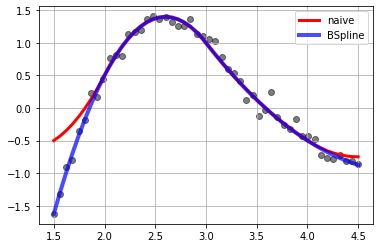

In [146]:
fig, ax = plt.subplots()
ax.plot(xx, [bspline(x, t, c ,k) for x in xx], 'r-', lw=3, label='naive')
ax.plot(xx, spl(xx), 'b-', lw=4, alpha=0.7, label='BSpline')
ax.scatter(xx, y, color='black', alpha=0.5)
ax.grid(True)
ax.legend(loc='best')
plt.show()

In [147]:
xx = np.linspace(1.5, 4.5, 50)
xx.shape

(50,)

here is an inefficient way to get splined curve and assuming we know the coefficients

In [148]:
n = len(t) - k - 1
b = np.empty((len(xx), n))
for i in range(len(xx)):
    for j in range(n):
        b[i, j] = B(xx[i], k, j, t)

In [149]:
c = np.array(c)
print(b.shape, c.shape)

(50, 4) (4,)


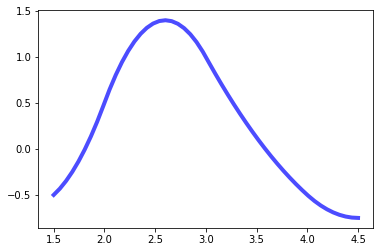

In [150]:
xx_bsplined = np.matmul(b, c)
fig, ax = plt.subplots()
ax.plot(xx, xx_bsplined, 'b-', lw=4, alpha=0.7, label='BSpline')

Let's use `patsy` to get the b-basis function and estimate coefficients in stan...

In [151]:
t = np.linspace(np.min(xx), np.max(xx), 4)
b = patsy.bs(xx, knots=t, degree=2)

In [152]:
print(b.shape)

(50, 6)


In [183]:
bspline_stan_code = """
data { 
  int num_data; 
  int num_basis; 
  vector[num_data] Y; 
  vector[num_data] X; 
  matrix[num_basis, num_data] B; 
} 
 
parameters { 
  row_vector[num_basis] a_raw; 
  real a0; 
  real<lower=0> sigma; 
  real<lower=0> tau; 
} 
 
transformed parameters {
  row_vector[num_basis] a;
  vector[num_data] Y_hat;
  a[1] = a_raw[1];
  for (i in 2:num_basis)
    // a[i] = a[i-1] + a_raw[i]*tau;
    a[i] = a[i-1] + a_raw[i]*tau;
  Y_hat = a0*to_vector(X) + to_vector(a*B);
}
 
model { 
  a_raw ~ double_exponential(0, 0.1); 
  // tau ~ cauchy(0, 1); 
  sigma ~ cauchy(0, 1); 
  Y ~ normal(Y_hat, sigma); 
} 
"""
sm = pystan.StanModel(model_code=bspline_stan_code)
with open('../models/cp_stan.pkl', 'wb') as f:
    pickle.dump(sm, f)
# with open('../models/cp_stan.pkl', 'rb') as f:
#     sm = pickle.load(f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33648494d1aa8107d12335098a7c595a NOW.


Let's say we didn't know the true number of knots and assume some smaller number of knots.

In [186]:
input_data = {
    'num_data': len(xx),
    'num_basis': b.shape[1],
    'Y':  y,
    'X': xx,
    'B': b.transpose(),
}

In [187]:
fit = sm.optimizing(data=input_data)
yhat = fit['Y_hat']
c0 = fit['a0']
c = fit['a']

RuntimeError: Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=Y; position=0; dims declared=(50); dims found=(1095)  (in 'unknown file name' at line 5)


In [ ]:
fig, ax = plt.subplots()
ax.plot(xx, yhat, 'r-', lw=3, label='stan_bspline')
ax.scatter(xx, y, color='black')
ax.grid(True)
ax.legend(loc='best')
plt.show()

## Revisit the change point using B-Spline

In [188]:
def sandwich_kernel(x, x_i):
    """
    x: points required to compute kernel weight
    x_i: reference points location used to compute correspondent distance of each entry points
    return:
        a matrix with N x M such that
        N as the number of entry points
        M as the number of reference points
        matrix entries hold the value of weight of each element
    see also:
      1. https://mc-stan.org/docs/2_24/stan-users-guide/gaussian-process-regression.html
      2. https://en.wikipedia.org/wiki/Local_regression
    """
    N = len(x)
    M = len(x_i)
    k = np.zeros((N, M), dtype=np.double)

    np_idx = np.where(x < x_i[0])
    k[np_idx, 0] = 1

    for m in range(M - 1):
        np_idx = np.where(np.logical_and(x >= x_i[m], x < x_i[m + 1]))
        total_dist = x_i[m + 1] - x_i[m]
        backward_dist = x[np_idx] - x_i[m]
        forward_dist = x_i[m + 1] - x[np_idx]
        k[np_idx, m] = forward_dist / total_dist
        k[np_idx, m + 1] = backward_dist / total_dist

    np_idx = np.where(x >= x_i[M - 1])
    k[np_idx, M - 1] = 1

    # TODO: it is probably not needed
    k = k / np.sum(k, axis=1, keepdims=True)

    return k

In [189]:
T = 365 * 3
N_KNOTS = 36
np.random.seed(2021)

In [190]:
noise = np.random.normal(0, 0.5, T)

In [191]:
is_jump = (np.random.uniform(0, 1, N_KNOTS) > 0.8).astype(np.int32)
is_jump

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [192]:
jump_size = np.random.normal(0, 3, N_KNOTS) 

In [193]:
knots = np.cumsum(is_jump * jump_size)

In [194]:
# normalize time
width = 1/len(knots)
tp = np.arange(1, T + 1)/ T
knots_tp = np.arange(width/2, 1, width)

In [195]:
K = sandwich_kernel(tp, knots_tp)

In [196]:
print(K.shape, knots.shape)

(1095, 36) (36,)


In [197]:
trend = np.matmul(K, knots)
y = trend + noise

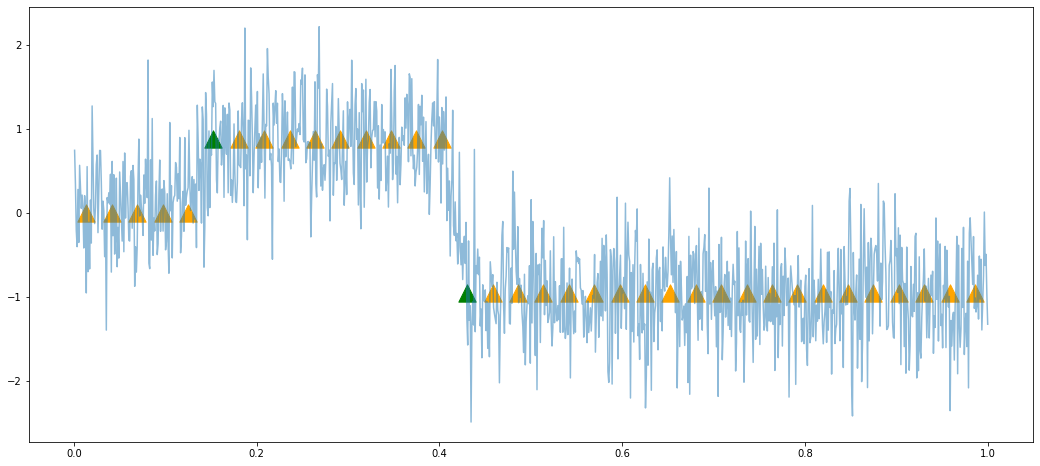

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green');
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange');

Question here: can we create a pyro to connect the knots?

In [199]:
tp.shape

(1095,)

In [285]:
knots_sim = np.linspace(np.min(tp), np.max(tp), 20)
b = patsy.bs(tp, knots=knots_sim[1:-1], degree=1)

In [286]:
input_data = {
    'num_data': len(tp),
    'num_basis': b.shape[1],
    'Y': y,
    'X': tp,
    'B': b.transpose(),
}

In [287]:
# fit = sm.sampling(data=input_data)
# yhat = fit['Y_hat']
# c0 = fit['a0']
# c = fit['a']

In [288]:
fit = sm.optimizing(data=input_data)
yhat = fit['Y_hat']
c0 = fit['a0']
c = fit['a']

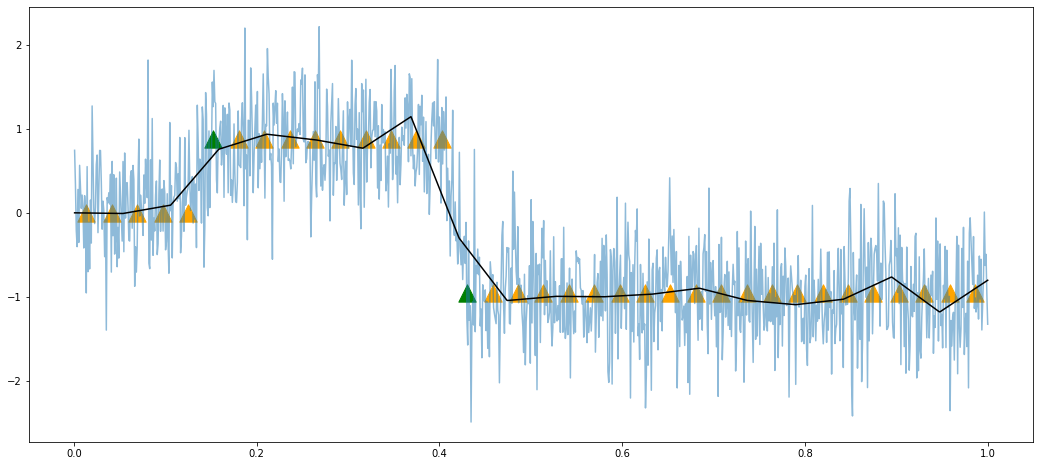

In [289]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green')
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange')
ax.plot(tp, yhat, label='fitted', color='black');
# if mcmc
# ax.plot(tp, np.median(yhat, 0), label='fitted', color='black');